In [22]:
from svmutil import *
import csv
import math
import random
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_from_file(path):
    data = []
    with open(path) as f:
        reader = csv.reader(f, delimiter=",")
        for row in reader:
            data.append([row[:-1], row[-1]])
    for column in range(len(data[0][0])):
        for row in data:
            row[0][column] = float(row[0][column].strip())
    return data


def write_data_for_scale(file_name, data):
    f = open(file_name, 'w')
    for row in data:
        line = str(row[-1])
        for i in xrange(len(row[0])):
                line += ' ' + str(i + 1) + ':' + str(row[0][i])
        line = line + '\n'
        f.write(line)
    f.close()


def get_standard_deviation(y_test, p_labels):
    errors = [y_test[i] - p_labels[i] for i in xrange(len(y_test))]
    std = np.std(errors)
    return std


def kfold_cross_validation(params, features, k, seed=None):
    partitions = partition(features, k, seed)
    errors = list()

    # Run the algorithm k times, record error each time
    for i in range(k):
        trainingSet = list()
        for j in range(k):
            if j != i:
                trainingSet.append(partitions[j])

        # flatten training set
        trainingSet = [item for entry in trainingSet for item in entry]
        testSet = partitions[i]
        y_train = [row[0] for row in trainingSet]
        x_train = [row[1] for row in trainingSet]
        # Train and classify model
        prob = svm_problem(y_train, x_train)
        trainedClassifier = svm_train(prob, params)
        y_test = [row[0] for row in testSet]
        x_test = [row[1] for row in testSet]
        p_labels, p_acc, p_vals = svm_predict(y_test, x_test, trainedClassifier)
        errors.append(p_acc[1])
    std = np.std(errors)
    mean = np.mean(errors)
    return mean, std


def partition(dataSet, k, seed=None):
    size = math.ceil(len(dataSet) / float(k))
    partitions = [[] for i in range(k)]
    j = 0

    for entry in dataSet:
        x = assign(partitions, k, size, seed)
        partitions[x].append(entry)

    return partitions


def assign(partitions, k, size, seed=None):
    if seed is not None:
        random.Random(seed)
    x = random.randint(0,k-1)
    while len(partitions[x]) >= size:
        x = random.randint(0,k-1)
    return x


def scale_data(file_path):
    data = read_from_file(file_path)
    train_file_name = "train"
    test_file_name = "test"
    train = data[:3450]
    test = data[3450:]
    write_data_for_scale(train_file_name, train)
    write_data_for_scale(test_file_name, test)
    args = "svm-scale.exe -l 0 -u 1 -s scale_params " + train_file_name
    fnull = open(os.devnull, 'w')
    train_file = open(train_file_name + '.scaled', 'w')
    subprocess.call(args, stdout=train_file, stderr=fnull, shell=False)
    train_file.close()
    test_file = open(test_file_name + ".scaled", 'w')
    args = "svm-scale.exe -l 0 -u 1 -r scale_params " + test_file_name
    subprocess.call(args, stdout=test_file, stderr=fnull, shell=False)
    test_file.close()
    fnull.close()

In [4]:
scale_data("sample.txt")
y_train, x_train = svm_read_problem("train.scaled")
y_test, x_test = svm_read_problem("test.scaled")
train_data = [[y_train[i], x_train[i]] for i in xrange(len(x_train))]
print train_data

[[0.0, {1: 0.0176211, 2: 0.0119048, 3: 0.0333333, 36: 0.0735294, 5: 0.0880088, 6: 0.0136054, 8: 0.0429043, 42: 0.00560224, 43: 0.022409, 12: 0.350569, 13: 0.0306306, 16: 0.004, 49: 0.00524515, 50: 0.00471698, 57: 0.0274621, 53: 0.00383142, 55: 0.00162469, 56: 0.00560673, 25: 0.128661, 37: 0.011611}], [0.0, {35: 0.111, 19: 0.1184, 57: 0.00138889, 55: 0.000753552, 56: 0.000700841, 25: 0.106577, 26: 0.133253}], [0.0, {9: 0.220532, 12: 0.119959, 13: 0.209009, 19: 0.0618667, 21: 0.10831, 55: 0.000195982, 56: 0.00020024, 57: 0.000694444, 27: 0.0348035}], [0.0, {10: 0.130913, 12: 0.492244, 52: 0.0136092, 55: 0.0011024, 56: 0.000901081, 57: 0.0010101}], [1.0, {3: 0.0627451, 5: 0.0715072, 6: 0.110544, 7: 0.0440165, 8: 0.0528053, 12: 0.033092, 13: 0.0576577, 45: 0.0149393, 16: 0.016, 17: 0.0448179, 50: 0.0108696, 19: 0.1216, 56: 0.000901081, 21: 0.304388, 55: 0.000484076, 24: 0.0328205, 57: 0.00871212, 53: 0.0264868}], [0.0, {56: 0.00030036, 57: 0.00094697, 55: 0.00022538}], [1.0, {1: 0.0770925,

In [16]:
def start_calculation(degree):
    x = []
    top = []
    middle = []
    bottom = []
    for k in xrange(-20, 21):
        print k
        svm_params = svm_parameter('-s 0 -t 1 -q -d ' + str(d) + ' -c ' + str(2**k))
        error, std = kfold_cross_validation(svm_params, train_data, k_fold_param)
        x.append(2**k)
        top.append(error)
        middle.append(error)
        bottom.append(error)
    return x, top, middle, bottom

In [33]:
def draw_error(x, error_top, error, error_bottom):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(x, error_top)
    plt.subplot(211)
    plt.plot(x, error)
    plt.subplot(211)
    plt.plot(x, error_bottom)

    plt.show()

In [18]:
k_fold_param = 10
d = 1
x1, top1, middle1, bottom1 = start_calculation(d)

-20
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 59.7101% (206/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 55.3623% (191/345) (classification)
Accuracy = 63.4783% (219/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
Accuracy = 58.8406% (203/345) (classification)
Accuracy = 61.4493% (212/345) (classification)
-19
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 57.971% (200/345) (classification)
Accuracy = 62.029% (214/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
Accuracy = 62.3188% (215/345) (classification)
Accuracy = 57.3913% (198/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 61.1594% (211/345) (classification)
Accuracy = 57.1014% (197/345) (classification)
-18
Accuracy = 60% (207/345) (classification)
Accuracy

Accuracy = 62.029% (214/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 60.2899% (208/345) (classification)
Accuracy = 66.087% (228/345) (classification)
-2
Accuracy = 61.4493% (212/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 62.3188% (215/345) (classification)
Accuracy = 57.1014% (197/345) (classification)
Accuracy = 55.942% (193/345) (classification)
Accuracy = 64.058% (221/345) (classification)
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 62.3188% (215/345) (classification)
Accuracy = 60.2899% (208/345) (classification)
-1
Accuracy = 62.8986% (217/345) (classification)
Accuracy = 56.5217% (195/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 62.029% (214/345) (classification)
Accuracy = 57.971% (200/345) (classification)
Accuracy = 62.029% (214/345) (classification)
Accuracy = 60.

Accuracy = 94.2029% (325/345) (classification)
15
Accuracy = 94.2029% (325/345) (classification)
Accuracy = 93.3333% (322/345) (classification)
Accuracy = 93.0435% (321/345) (classification)
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 93.0435% (321/345) (classification)
Accuracy = 91.8841% (317/345) (classification)
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 95.942% (331/345) (classification)
Accuracy = 90.7246% (313/345) (classification)
16
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 91.3043% (315/345) (classification)
Accuracy = 94.2029% (325/345) (classification)
Accuracy = 94.7826% (327/345) (classification)
Accuracy = 93.3333% (322/345) (classification)
Accuracy = 93.0435% (321/345) (classification)
Accuracy = 93.6232% (322/345) (classification)
Accuracy = 93.0435% (321/345) (classification)
Accuracy = 94.2029% (325/345) (classification)
Accuracy = 90.4348% (312/345) (classification)
17
Accur

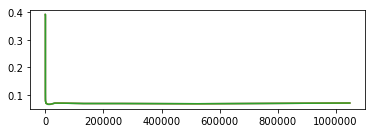

In [34]:
draw_error(x1, top1, middle1, bottom1)

In [35]:
d = 2
x2, top2, middle2, bottom2 = start_calculation(d)

-20
Accuracy = 59.7101% (206/345) (classification)
Accuracy = 61.4493% (212/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 63.7681% (220/345) (classification)
Accuracy = 58.2609% (201/345) (classification)
Accuracy = 57.6812% (199/345) (classification)
Accuracy = 64.058% (221/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
Accuracy = 56.5217% (195/345) (classification)
-19
Accuracy = 61.4493% (212/345) (classification)
Accuracy = 66.087% (228/345) (classification)
Accuracy = 60.8696% (210/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 57.6812% (199/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
Accuracy = 59.7101% (206/345) (classification)
Accuracy = 51.8841% (179/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 65.2174% (225/345) (classification)
-18
Accuracy = 63.4783% (219/345) (classification)
Acc

Accuracy = 65.5072% (226/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
Accuracy = 60% (207/345) (classification)
Accuracy = 59.7101% (206/345) (classification)
Accuracy = 63.7681% (220/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
-2
Accuracy = 63.4783% (219/345) (classification)
Accuracy = 55.6522% (192/345) (classification)
Accuracy = 59.1304% (204/345) (classification)
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 64.3478% (221/345) (classification)
Accuracy = 57.3913% (198/345) (classification)
Accuracy = 58.2609% (201/345) (classification)
Accuracy = 58.2609% (201/345) (classification)
Accuracy = 64.058% (221/345) (classification)
Accuracy = 64.058% (221/345) (classification)
-1
Accuracy = 58.2609% (201/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 62.029% (214/345) (classification)
Accuracy = 59.1304% (204/345) (classification)
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 62.6

Accuracy = 84.3478% (290/345) (classification)
15
Accuracy = 86.087% (297/345) (classification)
Accuracy = 89.8551% (309/345) (classification)
Accuracy = 86.087% (297/345) (classification)
Accuracy = 88.4058% (305/345) (classification)
Accuracy = 83.7681% (289/345) (classification)
Accuracy = 86.6667% (299/345) (classification)
Accuracy = 83.7681% (289/345) (classification)
Accuracy = 84.9275% (293/345) (classification)
Accuracy = 88.1159% (303/345) (classification)
Accuracy = 89.8551% (309/345) (classification)
16
Accuracy = 88.6957% (306/345) (classification)
Accuracy = 91.0145% (314/345) (classification)
Accuracy = 90.7246% (313/345) (classification)
Accuracy = 90.7246% (313/345) (classification)
Accuracy = 87.8261% (303/345) (classification)
Accuracy = 86.6667% (299/345) (classification)
Accuracy = 87.8261% (303/345) (classification)
Accuracy = 85.7971% (296/345) (classification)
Accuracy = 88.4058% (305/345) (classification)
Accuracy = 88.6957% (306/345) (classification)
17
Accura

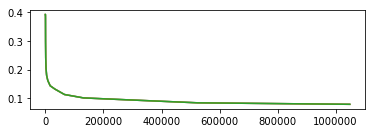

In [36]:
draw_error(x2, top2, middle2, bottom2)

In [37]:
d = 3
x3, top3, middle3, bottom3 = start_calculation(d)

-20
Accuracy = 61.4493% (212/345) (classification)
Accuracy = 60.2899% (208/345) (classification)
Accuracy = 58.8406% (203/345) (classification)
Accuracy = 64.9275% (224/345) (classification)
Accuracy = 55.6522% (192/345) (classification)
Accuracy = 58.5507% (202/345) (classification)
Accuracy = 59.1304% (204/345) (classification)
Accuracy = 66.3768% (229/345) (classification)
Accuracy = 63.7681% (220/345) (classification)
Accuracy = 58.2609% (201/345) (classification)
-19
Accuracy = 62.029% (214/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 60.8696% (210/345) (classification)
Accuracy = 57.6812% (199/345) (classification)
Accuracy = 65.2174% (225/345) (classification)
Accuracy = 57.1014% (197/345) (classification)
Accuracy = 60% (207/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
Accuracy = 62.8986% (217/345) (classification)
Accuracy = 56.5217% (195/345) (classification)
-18
Accuracy = 61.7391% (213/345) (classification)
Accurac

Accuracy = 62.029% (214/345) (classification)
Accuracy = 58.5507% (202/345) (classification)
Accuracy = 64.9275% (224/345) (classification)
Accuracy = 60% (207/345) (classification)
Accuracy = 60.2899% (208/345) (classification)
-2
Accuracy = 64.058% (221/345) (classification)
Accuracy = 62.3188% (215/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 57.3913% (198/345) (classification)
Accuracy = 62.6087% (216/345) (classification)
Accuracy = 61.1594% (211/345) (classification)
Accuracy = 59.7101% (206/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 57.971% (200/345) (classification)
Accuracy = 59.7101% (206/345) (classification)
-1
Accuracy = 61.4493% (212/345) (classification)
Accuracy = 59.1304% (204/345) (classification)
Accuracy = 60.8696% (210/345) (classification)
Accuracy = 60.2899% (208/345) (classification)
Accuracy = 64.058% (221/345) (classification)
Accuracy = 58.8406% (203/345) (classification)
Accuracy = 54.49

Accuracy = 59.1304% (204/345) (classification)
Accuracy = 57.971% (200/345) (classification)
Accuracy = 64.3478% (221/345) (classification)
Accuracy = 60.2899% (208/345) (classification)
Accuracy = 56.8116% (196/345) (classification)
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 62.8986% (217/345) (classification)
Accuracy = 62.8986% (217/345) (classification)
Accuracy = 63.1884% (218/345) (classification)
16
Accuracy = 61.7391% (213/345) (classification)
Accuracy = 61.1594% (211/345) (classification)
Accuracy = 63.7681% (220/345) (classification)
Accuracy = 62.8986% (217/345) (classification)
Accuracy = 60% (207/345) (classification)
Accuracy = 59.7101% (206/345) (classification)
Accuracy = 57.3913% (198/345) (classification)
Accuracy = 62.3188% (215/345) (classification)
Accuracy = 60.8696% (210/345) (classification)
Accuracy = 68.1159% (234/345) (classification)
17
Accuracy = 69.2754% (239/345) (classification)
Accuracy = 71

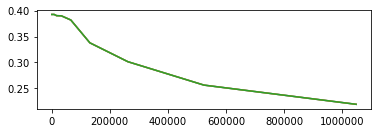

In [38]:
draw_error(x3, top3, middle3, bottom3)

In [ ]:
d = 4
x4, top4, middle4, bottom4 = start_calculation(d)

In [ ]:
draw_error(x4, top4, middle4, bottom4)

In [ ]:
def start_calculation_with_c(dataset, c):
    x = []
    errors = []
    for d in xrange(1, 10):
        print d
        svm_params = svm_parameter('-s 0 -t 1 -q -d ' + str(d) + ' -c ' + str(c))
        error, std = kfold_cross_validation(svm_params, dataset, k_fold_param)
        errors.append(error)
    return x, errors

In [ ]:
best_c = 1
start_calculation_with_c(train_data, best_c)